In [6]:
import sys
sys.path.append("/home/ferrari/anaconda3/lib/python3.7/site-packages/")
from adjustText import adjust_text
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import RELACS as rel
import matplotlib
import matplotlib.cm as cm
from matplotlib import colors
sns.set_style("white")
sns.set_context("paper")
%load_ext rpy2.ipython
%matplotlib inline

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Perform differential analysis for the contrast EPZ vs DMSO in mESC and NPC48h 

/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: estimating size factors

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: estimating dispersions

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: gene-wise dispersion estimates

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: mean-dispersion relationship

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: final dispersion estimates

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: fitting model and testing

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib

$rank
 [1]   636.9  1273.8  1910.7  2547.6  3184.5  3821.4  4458.3  5095.2  5732.1
[10]  6369.0  7005.9  7642.8  8279.7  8916.6  9553.5 10190.4 10827.3 11464.2
[19] 12101.1 12738.0 13374.9 14011.8 14648.7 15285.6 15922.5 16559.4 17196.3
[28] 17833.2 18470.1 19107.0 19743.9 20380.8 21017.7 21654.6 22291.5 22928.4
[37] 23565.3 24202.2 24839.1

$sd
 [1] 0.01873194 0.01982322 0.02234551 0.02531476 0.02915416 0.03305536
 [7] 0.03708261 0.04203128 0.04849020 0.05569906 0.06440750 0.07391437
[13] 0.08358828 0.09636157 0.11042028 0.12694639 0.14296523 0.16144858
[19] 0.18141075 0.19528036 0.20632145 0.21475740 0.21423404 0.20307894
[25] 0.19015289 0.17584980 0.16570923 0.15926585 0.15252936 0.14567182
[31] 0.14054169 0.13600918 0.13609858 0.13742649 0.13805521 0.13979751
[37] 0.13993452 0.14010131 0.14013419

$px
 ENSMUSG00000000001.4 ENSMUSG00000000028.15 ENSMUSG00000000031.16 
                24545                 20334                 25273 
ENSMUSG00000000037.16  ENSMUSG00000000056.7  ENSM

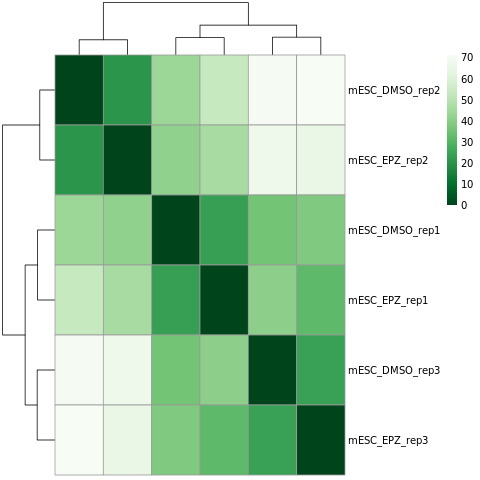

In [4]:
%%R 

                                    ##############################################
                                    ### Differential Analysis mESC EPZ vs DMSO ###
                                    ##############################################

out_dir = "../INTERMEDIATE_FILES"
out_dir_plots = "../FIGURES"

### LOAD PACKAGES ###
libr = "/home/ferrari/R/x86_64-redhat-linux-gnu-library/3.5/"
library(DESeq2, lib=libr)
library(rtracklayer, lib=libr)
library(vsn, lib=libr)
library(RColorBrewer, lib=libr)
library(pheatmap, lib=libr)
library(limma, lib=libr)

### LOAD COUNT TABLE ###
count=read.csv("../INPUT_DATA/counts_mESC.tsv", sep='\t', header = T, comment.char = '#')
rownames(count) = count$GeneID
count$GeneID = NULL


### prepare design table ###
design_table=data.frame(row.names = colnames(count),
                        condition = c(rep("DMSO",3), rep("EPZ",3)),
                        batch = rep(c("1","2","3"),2))

#print(all(rownames(design_table) == colnames(count)))

### create dds object ###
dds <- DESeqDataSetFromMatrix(countData = count,
                              colData = design_table,
                              design = ~ batch + condition)


### add feature data ### 
library(rtracklayer)

anno18 <- import.gff2("/data/manke/group/ferrari/my_repository/annotations_gencode/mouse/M18/gencode.vM18.annotation.sorted.gtf", feature.type = "gene")

featureData = data.frame(row.names = anno18$gene_id,
                         gene_name = anno18$gene_name,
                         gene_type = anno18$gene_type,
                         level = anno18$level,
                         chr = seqnames(anno18))

index=match(row.names(dds),row.names(featureData))
mcols(dds) = DataFrame(mcols(dds), featureData[index,])


### PREFILTERING ###
keep = rowSums(counts(dds)) >= 10
dds = dds[keep,]

### SET REFERENCE LEVELS ###
dds$condition = relevel(dds$condition, ref = "DMSO")


#########################
### SAMPLE CLUSTERING ### 
#########################

rld <- rlog(dds, blind=FALSE)

### Mean/sd plot ###
pdf(paste(out_dir,'Mean_SDplot_mESC_EPZvsDMSO.pdf',sep="/"), height = 5)
graph = meanSdPlot(assay(rld))
print(graph)
dev.off()

### Compute eucledian distance between samples ###
sampleDists = dist(t(assay(rld)))

### hierarchical clustering of samples based on distance ###
sampleDistMatrix = as.matrix(sampleDists)
rownames(sampleDistMatrix) = colnames(dds)
colnames(sampleDistMatrix) = NULL
colors <- colorRampPalette(rev(brewer.pal(9, "Greens")) )(255)

save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}

xx = pheatmap(sampleDistMatrix,
         clustering_distance_rows=sampleDists,
         clustering_distance_cols=sampleDists,
         col=colors)
save_pheatmap_pdf(xx, paste(out_dir_plots,"eucledian_distance_clustering_mESC_EPZvsDMSO.pdf",sep="/"))


### PCA before batch correction ###
pdf(paste(out_dir,'PCA_mESC_EPZvsDMSO.pdf',sep="/"))
graph = plotPCA(rld, intgroup='condition')
print(graph)
dev.off()

A=plotPCA(rld, ntop=500, returnData=T, intgroup=c("condition"))

write.table(A, paste(out_dir,"PCA_mESC.tsv",sep="/"), sep="\t", quote = F)



### PCA after batch correction ###
rld_batch = as.matrix(removeBatchEffect(assay(rld), batch = rep(c("1","2","3"),2)))
assay(rld) = rld_batch
pdf(paste(out_dir,'PCA_BATCH-CORRECTED_mESC_EPZvsDMSO.pdf',sep="/"))
graph = plotPCA(rld, intgroup='condition')
print(graph)
dev.off()

########################################
### DIFFERENTIAL EXPRESSION ANALYSIS ###
########################################

dds = DESeq(dds)

#print(resultsNames(dds))

res=results(dds)
res_lfc_cutoff = results(dds, lfcThreshold=0.3, altHypothesis="greaterAbs")
resLFC_normal = lfcShrink(dds, coef=tail(resultsNames(dds),n=1), type="normal")
resLFC_apeglm = lfcShrink(dds, coef=tail(resultsNames(dds),n=1), type="apeglm")


res$symbol=mcols(dds)$gene_name
res_lfc_cutoff$symbol=mcols(dds)$gene_name
resLFC_normal$symbol=mcols(dds)$gene_name
resLFC_apeglm$symbol=mcols(dds)$gene_name
  

### write results to file ###
resOrdered = as.data.frame(res[order(res$padj),])
write.table(resOrdered, 
            file = paste(out_dir,"DE_genes_basic_mESC_EPZvsDMSO.tsv",sep="/"), 
            quote = F, 
            sep = '\t')

resOrdered_lfc = as.data.frame(res_lfc_cutoff[order(res_lfc_cutoff$padj),])
write.table(resOrdered_lfc, 
            file = paste(out_dir,"DE_genes_lfcCutoff03_mESC_EPZvsDMSO.tsv",sep="/"),
            quote = F, 
            sep = '\t')

resLFC_normal_ordered = as.data.frame(resLFC_normal[order(resLFC_normal$padj),])
write.table(resLFC_normal_ordered, 
            file = paste(out_dir,"DE_genes_shrinked_normal_mESC_EPZvsDMSO.tsv",sep="/"), 
            quote = F, 
            sep = '\t')

resLFC_apeglm_ordered = as.data.frame(resLFC_apeglm[order(resLFC_apeglm$padj),])
write.table(resLFC_apeglm_ordered, 
            file = paste(out_dir,"DE_genes_shrinked_apeglm_mESC_EPZvsDMSO.tsv", sep="/"), 
            quote = F, 
            sep = '\t')


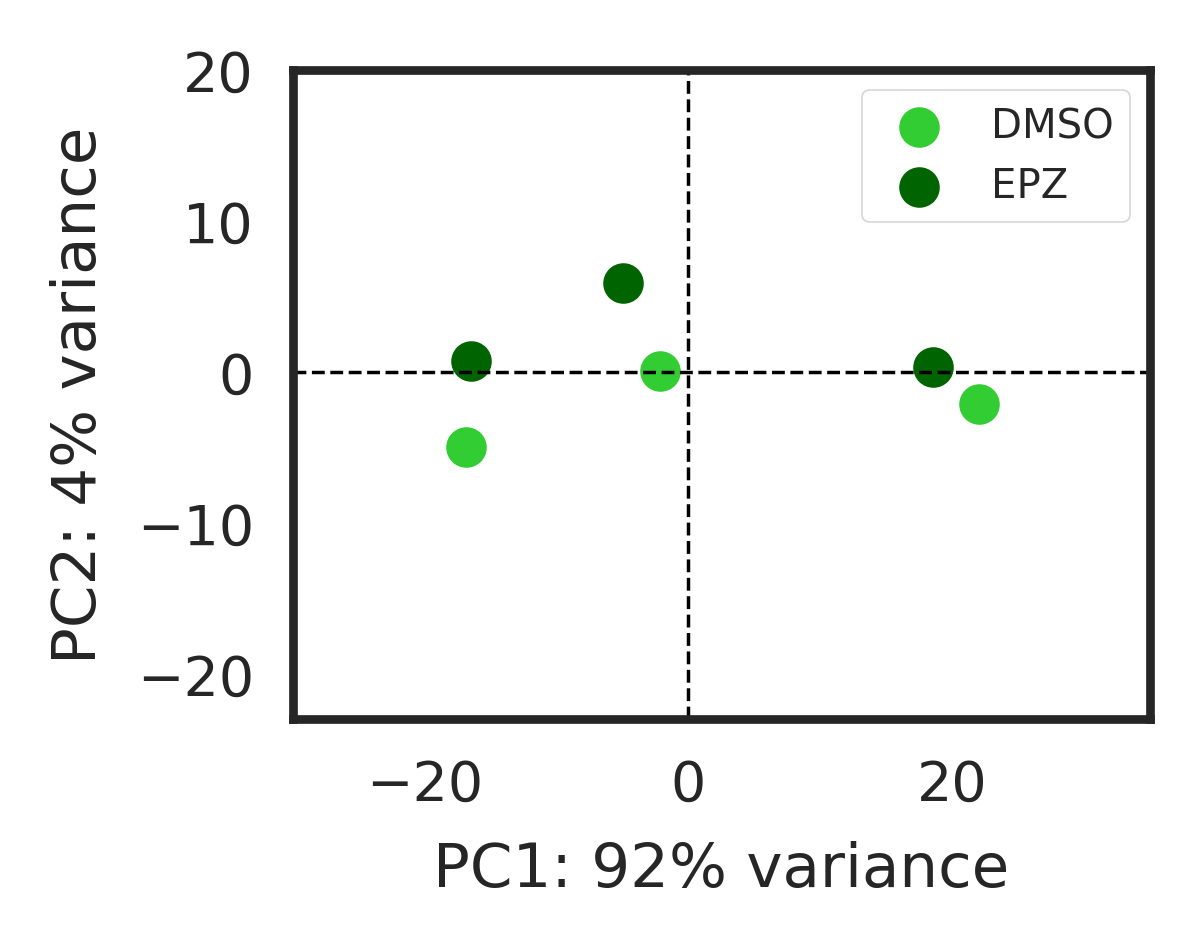

In [4]:
### PLOT PCA FOR mESC ###
### this is a python plotting of the results coming from the R analysis ###
### the original PCA plot is found in ../INTERMEDIATE_FILES/PCA_mESC_EPZvsDMSO.pdf ###

pca_esc = pd.read_csv("../INTERMEDIATE_FILES/PCA_mESC.tsv", sep="\t")
fig,ax=plt.subplots(dpi=500, figsize=(2.5,2))
dmso = (pca_esc.condition == "DMSO")
epz = (pca_esc.condition == "EPZ")
ax.scatter(pca_esc.PC1.loc[dmso],pca_esc.PC2.loc[dmso], color='limegreen',label="DMSO")
ax.scatter(pca_esc.PC1.loc[epz],pca_esc.PC2.loc[epz], color='darkgreen',label="EPZ")
ax.set_xlabel("PC1: 92% variance") 
ax.set_ylabel("PC2: 4% variance")
ax.axvline(0,linestyle="--",linewidth=0.5, color='k')
ax.axhline(0,linestyle="--",linewidth=0.5, color='k')
ax.set_ylim((-23,20))
ax.set_xlim((-30,35))
plt.legend(fontsize='xx-small', frameon=True)
plt.tight_layout()

# plt.savefig("../FIGURES/PCA_mESC_python.pdf")

/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: estimating size factors

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: estimating dispersions

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: gene-wise dispersion estimates

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: mean-dispersion relationship

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: final dispersion estimates

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: fitting model and testing

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib

$rank
 [1]   661.95  1323.90  1985.85  2647.80  3309.75  3971.70  4633.65  5295.60
 [9]  5957.55  6619.50  7281.45  7943.40  8605.35  9267.30  9929.25 10591.20
[17] 11253.15 11915.10 12577.05 13239.00 13900.95 14562.90 15224.85 15886.80
[25] 16548.75 17210.70 17872.65 18534.60 19196.55 19858.50 20520.45 21182.40
[33] 21844.35 22506.30 23168.25 23830.20 24492.15 25154.10 25816.05

$sd
 [1] 0.01698881 0.01797248 0.01993201 0.02229746 0.02452350 0.02720637
 [7] 0.03086379 0.03521243 0.03969611 0.04546885 0.05251969 0.06007150
[13] 0.07000475 0.08057011 0.09262527 0.10809272 0.12506996 0.14680367
[19] 0.17429330 0.19818515 0.21664327 0.21929812 0.21866380 0.20832517
[25] 0.19327512 0.18252692 0.16751832 0.15827354 0.15070387 0.14613528
[31] 0.14129639 0.13844900 0.13621378 0.13552352 0.13851968 0.13977951
[37] 0.14030432 0.14500978 0.14675196

$px
 ENSMUSG00000000001.4 ENSMUSG00000000028.15 ENSMUSG00000000031.16 
                25278                 17170                 25897 
ENSMUSG000

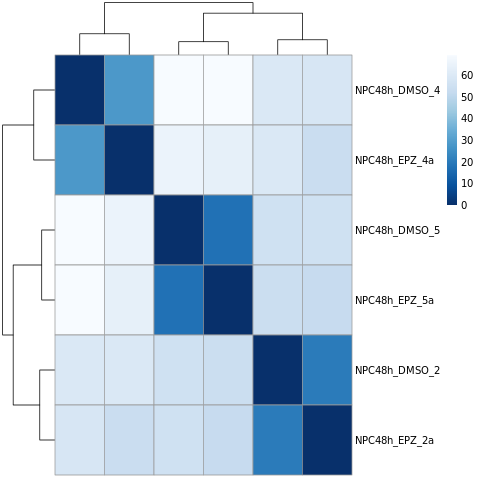

In [13]:
%%R 

                                    ################################################
                                    ### Differential Analysis NPC48h EPZ vs DMSO ###
                                    ################################################

out_dir = "../INTERMEDIATE_FILES"

### LOAD PACKAGES ###
libr = "/home/ferrari/R/x86_64-redhat-linux-gnu-library/3.5/"
library(DESeq2, lib=libr)
library(rtracklayer, lib=libr)
library(vsn, lib=libr)
library(RColorBrewer, lib=libr)
library(pheatmap, lib=libr)
library(limma, lib=libr)

### LOAD COUNT TABLE ###
count=read.csv("../INPUT_DATA/counts_NPC48h_corrected.tsv", sep='\t', header = T, comment.char = '#')
rownames(count) = count$GeneID
count$GeneID = NULL
colnames(count) = c("NPC48h_DMSO_2","NPC48h_EPZ_2a",
                    "NPC48h_DMSO_4","NPC48h_EPZ_4a",
                    "NPC48h_DMSO_5","NPC48h_EPZ_5a")
count

### prepare design table ###
design_table=data.frame(row.names = colnames(count),
                        condition = rep(c("DMSO","EPZ"),3),
                        batch = c("1","1","2","2","3","3"))

#print(all(rownames(design_table) == colnames(count)))

### create dds object ###
dds <- DESeqDataSetFromMatrix(countData = count,
                              colData = design_table,
                              design = ~ batch + condition)


### add feature data ### 
library(rtracklayer)

anno18 <- import.gff2("/data/manke/group/ferrari/my_repository/annotations_gencode/mouse/M18/gencode.vM18.annotation.sorted.gtf", feature.type = "gene")

featureData = data.frame(row.names = anno18$gene_id,
                         gene_name = anno18$gene_name,
                         gene_type = anno18$gene_type,
                         level = anno18$level,
                         chr = seqnames(anno18))

index=match(row.names(dds),row.names(featureData))
mcols(dds) = DataFrame(mcols(dds), featureData[index,])


### PREFILTERING ###
keep = rowSums(counts(dds)) >= 10
dds = dds[keep,]

### SET REFERENCE LEVELS ###
dds$condition = relevel(dds$condition, ref = "DMSO")


#########################
### SAMPLE CLUSTERING ### 
#########################

rld <- rlog(dds, blind=FALSE)

### Mean/sd plot ###
pdf(paste(out_dir,'Mean_SDplot_NPC48h_EPZvsDMSO.pdf',sep="/"), height = 5)
graph = meanSdPlot(assay(rld))
print(graph)
dev.off()

### Compute eucledian distance between samples ###
sampleDists = dist(t(assay(rld)))

### hierarchical clustering of samples based on distance ###
sampleDistMatrix = as.matrix(sampleDists)
rownames(sampleDistMatrix) = colnames(dds)
colnames(sampleDistMatrix) = NULL
colors <- colorRampPalette(rev(brewer.pal(9, "Blues")) )(255)

save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}

xx = pheatmap(sampleDistMatrix,
         clustering_distance_rows=sampleDists,
         clustering_distance_cols=sampleDists,
         col=colors)
save_pheatmap_pdf(xx, paste(out_dir_plots,"eucledian_distance_clustering_NPC48h_EPZvsDMSO.pdf",sep="/"))


### PCA before batch correction ###
pdf(paste(out_dir,'PCA_NPC48h_EPZvsDMSO.pdf',sep="/"))
graph = plotPCA(rld, intgroup='condition')
print(graph)
dev.off()

A=plotPCA(rld, ntop=500, returnData=T, intgroup=c("condition"))

write.table(A, paste(out_dir,"PCA_NPC48h.tsv",sep="/"), sep="\t", quote = F)

### PCA after batch correction ###
rld_batch = as.matrix(removeBatchEffect(assay(rld), batch = c("1","1","2","2","3","3")))
assay(rld) = rld_batch
pdf(paste(out_dir,'PCA_BATCH-CORRECTED_NPC48h_EPZvsDMSO.pdf',sep="/"))
graph = plotPCA(rld, intgroup='condition')
print(graph)
dev.off()

########################################
### DIFFERENTIAL EXPRESSION ANALYSIS ###
########################################

dds = DESeq(dds)

#print(resultsNames(dds))

res=results(dds)
res_lfc_cutoff = results(dds, lfcThreshold=0.3, altHypothesis="greaterAbs")
resLFC_normal = lfcShrink(dds, coef=tail(resultsNames(dds),n=1), type="normal")
resLFC_apeglm = lfcShrink(dds, coef=tail(resultsNames(dds),n=1), type="apeglm")


res$symbol=mcols(dds)$gene_name
res_lfc_cutoff$symbol=mcols(dds)$gene_name
resLFC_normal$symbol=mcols(dds)$gene_name
resLFC_apeglm$symbol=mcols(dds)$gene_name
  

### write results to file ###
resOrdered = as.data.frame(res[order(res$padj),])
write.table(resOrdered, 
            file = paste(out_dir,"DE_genes_basic_NPC48h_EPZvsDMSO.tsv",sep="/"), 
            quote = F, 
            sep = '\t')

resOrdered_lfc = as.data.frame(res_lfc_cutoff[order(res_lfc_cutoff$padj),])
write.table(resOrdered_lfc, 
            file = paste(out_dir,"DE_genes_lfcCutoff03_NPC48h_EPZvsDMSO.tsv",sep="/"),
            quote = F, 
            sep = '\t')

resLFC_normal_ordered = as.data.frame(resLFC_normal[order(resLFC_normal$padj),])
write.table(resLFC_normal_ordered, 
            file = paste(out_dir,"DE_genes_shrinked_normal_NPC48h_EPZvsDMSO.tsv",sep="/"), 
            quote = F, 
            sep = '\t')

resLFC_apeglm_ordered = as.data.frame(resLFC_apeglm[order(resLFC_apeglm$padj),])
write.table(resLFC_apeglm_ordered, 
            file = paste(out_dir,"DE_genes_shrinked_apeglm_NPC48h_EPZvsDMSO.tsv", sep="/"), 
            quote = F, 
            sep = '\t')



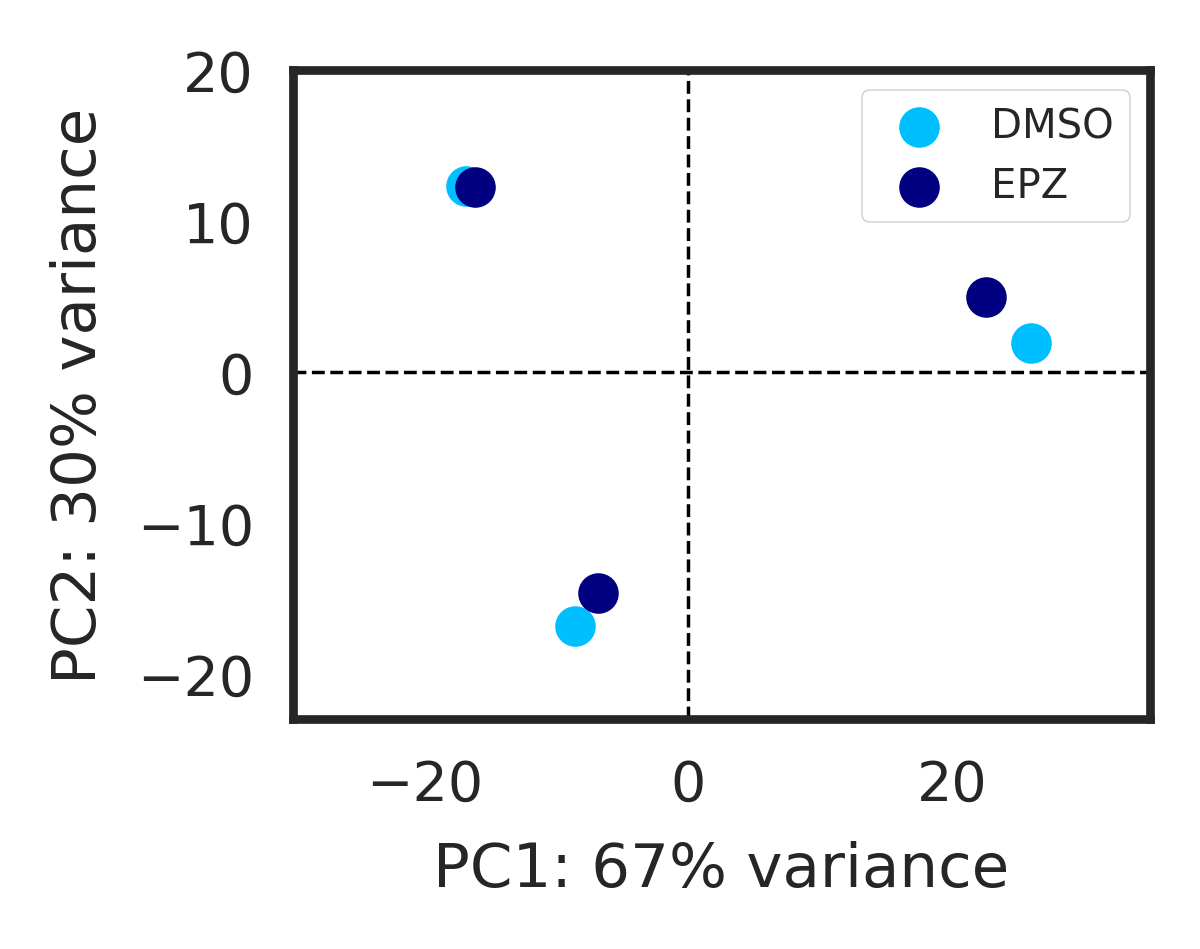

In [21]:
### PLOT PCA FOR NPC48h ###
### this is a python plotting of the results coming from the R analysis ###
### the original PCA plot is found in ../INTERMEDIATE_FILES/PCA_NPC48h_EPZvsDMSO.pdf ###


pca_npc = pd.read_csv("../INTERMEDIATE_FILES/PCA_NPC48h.tsv", sep="\t")
fig,ax=plt.subplots(dpi=500, figsize=(2.5,2))

ax.scatter(pca_npc.PC1.loc[pca_npc.condition == "DMSO"],pca_npc.PC2.loc[pca_npc.condition == "DMSO"], color='deepskyblue',label="DMSO")
ax.scatter(pca_npc.PC1.loc[pca_npc.condition == "EPZ"],pca_npc.PC2.loc[pca_npc.condition == "EPZ"], color='navy',label="EPZ")
ax.set_xlabel("PC1: 67% variance")
ax.set_ylabel("PC2: 30% variance")
ax.axvline(0,linestyle="--",linewidth=0.5, color='k')
ax.axhline(0,linestyle="--",linewidth=0.5, color='k')
ax.set_ylim((-23,20))
ax.set_xlim((-30,35))
plt.legend(fontsize='xx-small', frameon=True)
plt.tight_layout()
plt.savefig("../FIGURES/PCA_NPC48h_python.pdf")

# Visualize results of differential expression analysis

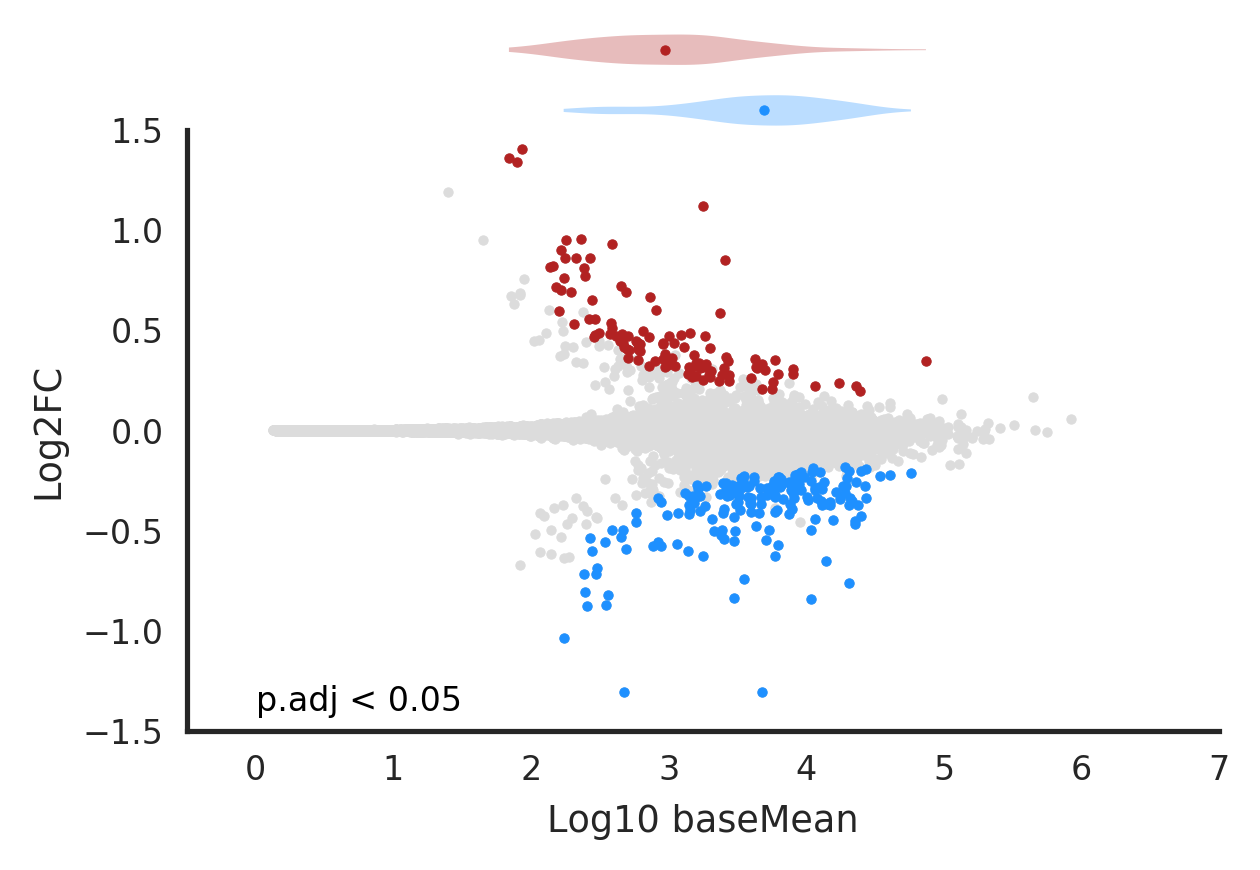

In [5]:
### MA PLOT FOR NPC48h ###

npc = pd.read_csv("../INTERMEDIATE_FILES/DE_genes_shrinked_apeglm_NPC48h_EPZvsDMSO.tsv", sep="\t")

pval_thr = 0.05

up = (npc.padj <pval_thr) & (npc.log2FoldChange > 0)
down = (npc.padj <pval_thr) & (npc.log2FoldChange < 0)

fig,ax = plt.subplots(2,1,dpi=300,figsize=(4.3,3), gridspec_kw={'height_ratios': [1, 6],"hspace":0})

ax[0].axis('off')
ax[0].set_xlim((-0.5,7))
cols=['dodgerblue','firebrick']
vp = ax[0].violinplot([np.log10(npc.baseMean.loc[down]), np.log10(npc.baseMean.loc[up])],[0,1], 
                      vert=False, showextrema=False, showmedians=False)
ax[0].scatter(np.median(np.log10(npc.baseMean.loc[down])),[0], color='dodgerblue',s=5)
ax[0].scatter(np.median(np.log10(npc.baseMean.loc[up])),[1], color='firebrick',s=5)

for i in range(len(vp['bodies'])):
    vp['bodies'][i].set_facecolor(cols[i])

    
ax[1].scatter(np.log10(npc.baseMean),npc.log2FoldChange,color="gainsboro", s=5)
ax[1].scatter(np.log10(npc.baseMean.loc[up]),npc.log2FoldChange.loc[up],color="firebrick", s=5)
ax[1].scatter(np.log10(npc.baseMean.loc[down]),npc.log2FoldChange.loc[down],color="dodgerblue", s=5)
# ax[1].annotate(sum(up), (5,1), color="firebrick", size=15)
# ax[1].annotate(sum(down), (5,-1), color="dodgerblue", size=15)
ax[1].annotate("p.adj < {}".format(pval_thr), (0,-1.4), color="k", size=8)
ax[1].set_ylim((-1.5,1.5))
ax[1].set_xlim((-0.5,7))
ax[1].set_ylabel("Log2FC")
ax[1].set_xlabel("Log10 baseMean")
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
plt.tight_layout()
# plt.savefig("../FIGURES/MA_plot_NPC48h_shrinked.png")

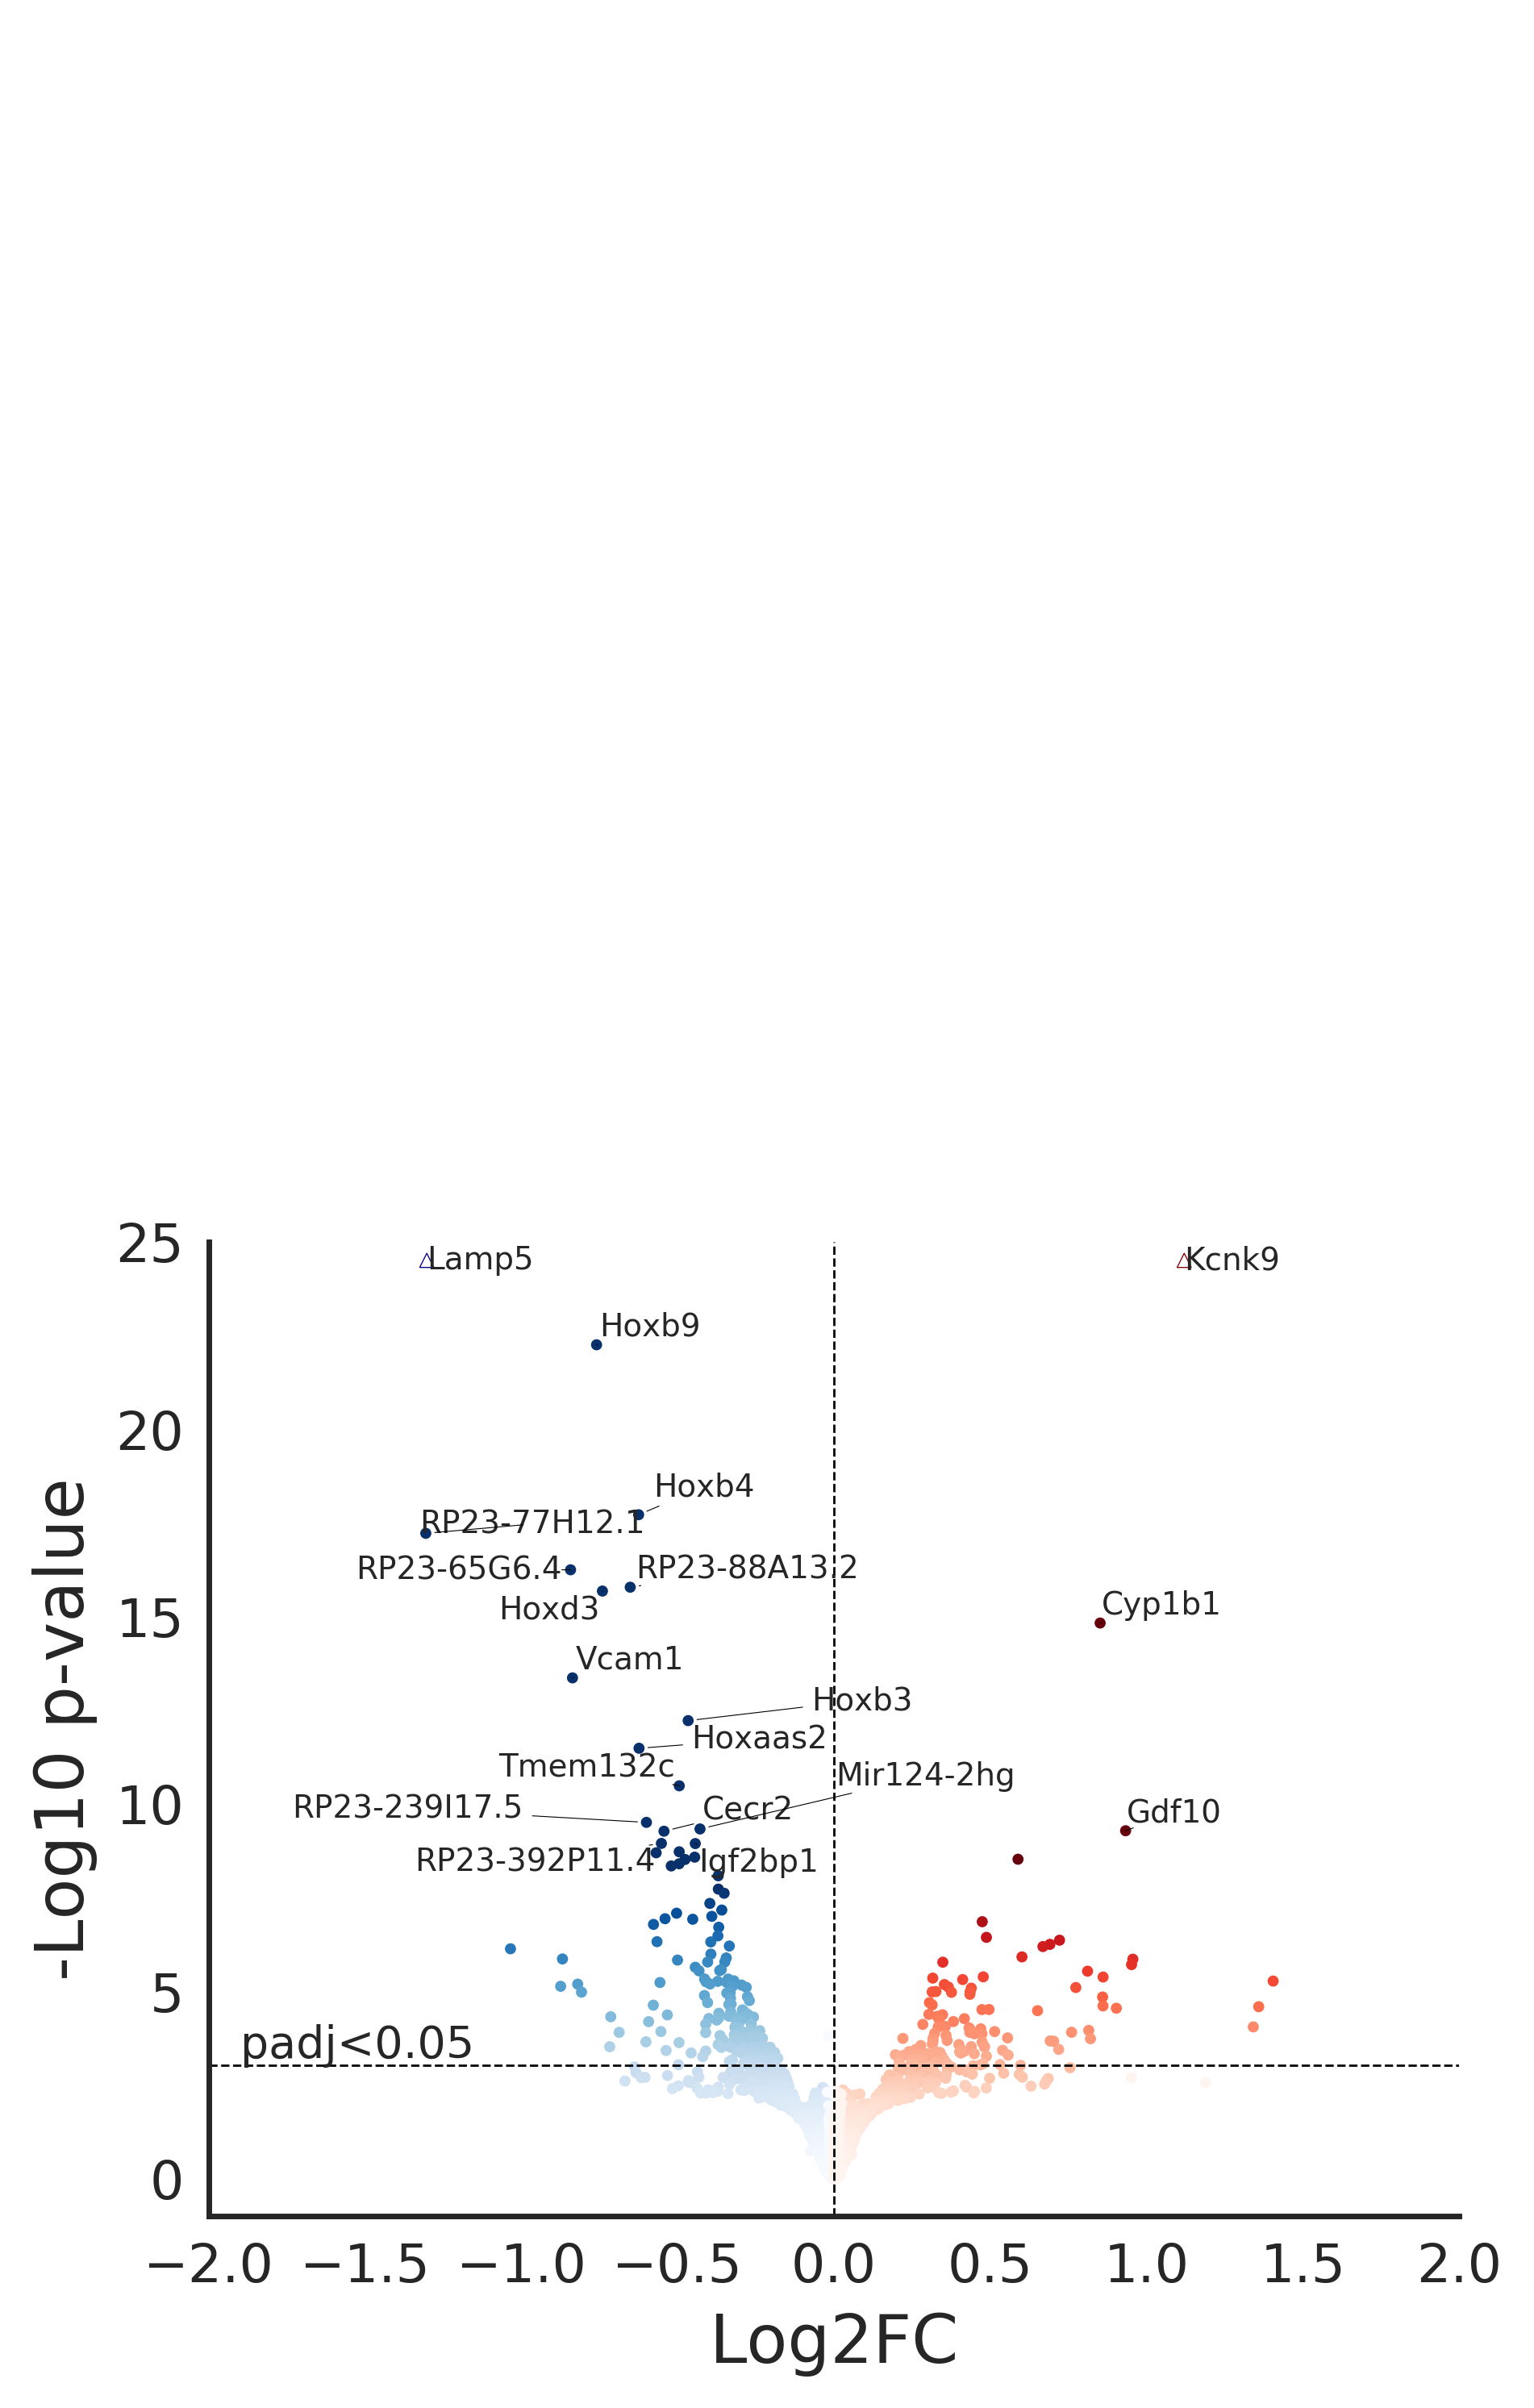

In [7]:
### VOLCANO PLOT FOR NPC48h ###

fig,ax=plt.subplots(dpi=400,figsize=(5,4))
npc["minLogPval"] = -np.log10(npc.pvalue)
npc["minLogPadj"] = -np.log10(npc.padj)

npc_up = npc.loc[npc.log2FoldChange>0]
npc_down = npc.loc[npc.log2FoldChange<0]

ax.set_ylim(-1,25)
ax.set_xlim(-2,2)

minima = 0
maxima = 5
norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues)
mapper.set_array(npc_down.minLogPadj)
rgba_list=[]
for v in npc_down["minLogPadj"]:
            rgba_list.append(mapper.to_rgba(v))
ax.scatter(npc_down.log2FoldChange, npc_down.minLogPval,s=5,c=rgba_list)
# plt.colorbar(mapper,shrink=0.5)
minima = 0
maxima = 5
norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Reds)
mapper.set_array(npc_up.minLogPadj)
rgba_list=[]
for v in npc_up["minLogPadj"]:
            rgba_list.append(mapper.to_rgba(v))

ax.scatter(npc_up.log2FoldChange, npc_up.minLogPval,s=5,c=rgba_list)
# plt.colorbar(mapper,shrink=0.5)
ax.axvline(0,linestyle='--',linewidth=0.5,color='k')


above = npc.loc[npc.minLogPval>25]
ax.scatter(above.log2FoldChange.values, [24.5,24.5],s=10,edgecolor=['navy','maroon'],facecolor=["white","white"], marker="^")

padj_thr = 0.000001

idx = npc.loc[(npc.padj<padj_thr)&(npc.log2FoldChange<-0.2)].index
idx2 = npc.loc[(npc.padj<padj_thr)&(npc.log2FoldChange>0.2)].index


texts = [plt.text(npc["log2FoldChange"].loc[idx].values[i], npc["minLogPval"].loc[idx].values[i], "{}".format(npc[["symbol"]].loc[(npc.padj<padj_thr)&(npc.log2FoldChange<0)].values[i][0]), ha='center', va='center',  fontsize=7) for i in range(len(idx))]
texts2 = [plt.text(npc["log2FoldChange"].loc[idx2].values[i], npc["minLogPval"].loc[idx2].values[i], "{}".format(npc[["symbol"]].loc[(npc.padj<padj_thr)&(npc.log2FoldChange>0)].values[i][0]), ha='center', va='center',  fontsize=7) for i in range(len(idx2))]


adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.2))
adjust_text(texts2, arrowprops=dict(arrowstyle="-", color='k', lw=0.2))


pthr = 0.05
pval_thr = -np.log10(npc.loc[npc.padj<pthr].tail(n=1)["pvalue"].values[0])
ax.axhline(pval_thr,linestyle='--',linewidth=0.5,color='k')
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
ax.annotate("padj<{}".format(pthr),[-1.9,pval_thr+0.2],size=10)
ax.set_ylabel("-Log10 p-value", fontsize=15)
ax.set_xlabel("Log2FC", fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig("../FIGURES/Volcano_plot_gradient_NPC48h.png")

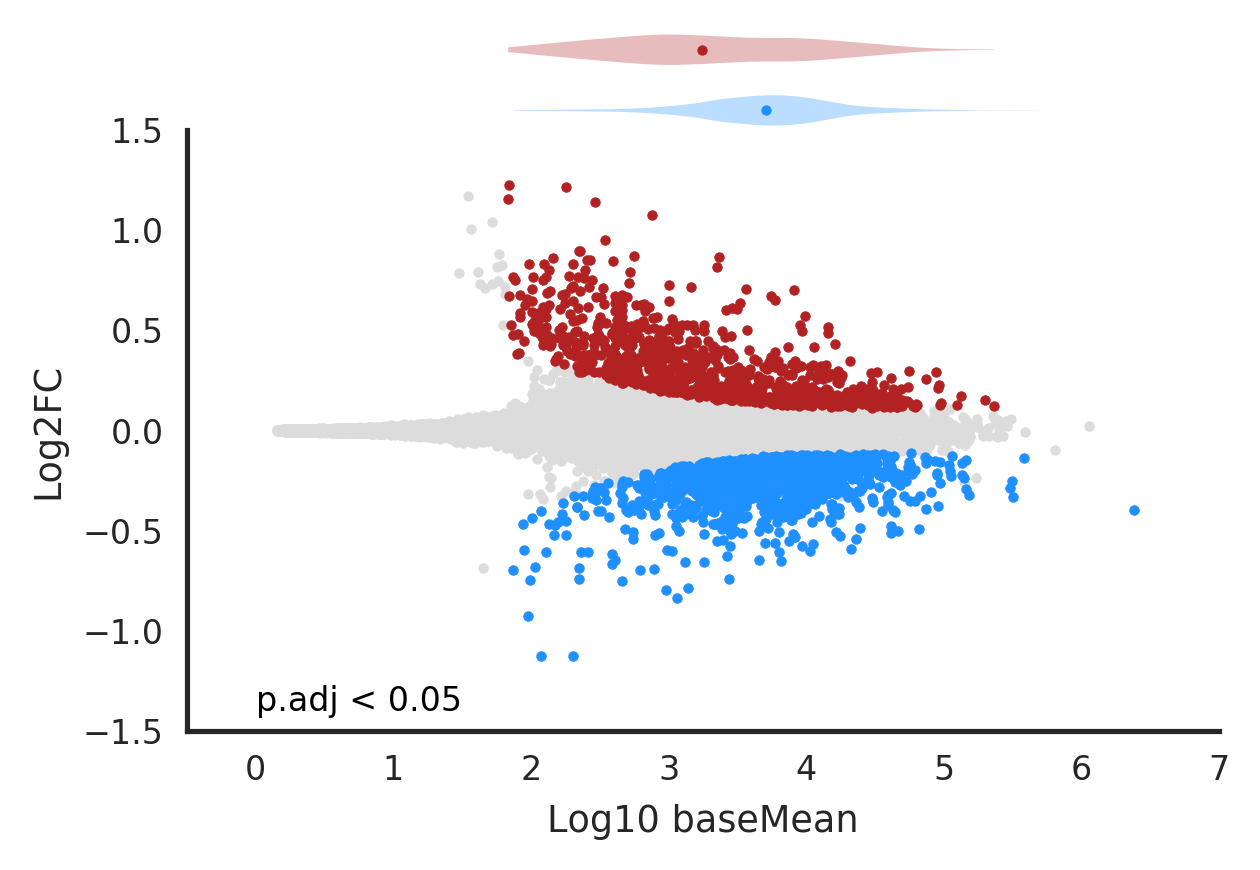

In [8]:
### MA PLOT FOR mESC ###

esc = pd.read_csv("../INTERMEDIATE_FILES/DE_genes_shrinked_apeglm_mESC_EPZvsDMSO.tsv", sep="\t")

pval_thr = 0.05

up = (esc.padj <pval_thr) & (esc.log2FoldChange > 0)
down = (esc.padj <pval_thr) & (esc.log2FoldChange < 0)

fig,ax = plt.subplots(2,1,dpi=300,figsize=(4.3,3), gridspec_kw={'height_ratios': [1, 6], "hspace":0})

ax[0].axis('off')
ax[0].set_xlim((-0.5,7))
cols=['dodgerblue','firebrick']
vp = ax[0].violinplot([np.log10(esc.baseMean.loc[down]), np.log10(esc.baseMean.loc[up])],[0,1], 
                      vert=False, showextrema=False, showmedians=False)
ax[0].scatter(np.median(np.log10(esc.baseMean.loc[down])),[0], color='dodgerblue',s=5)
ax[0].scatter(np.median(np.log10(esc.baseMean.loc[up])),[1], color='firebrick',s=5)

for i in range(len(vp['bodies'])):
    vp['bodies'][i].set_facecolor(cols[i])

ax[1].scatter(np.log10(esc.baseMean),esc.log2FoldChange,color="gainsboro", s=5)
ax[1].scatter(np.log10(esc.baseMean.loc[up]),esc.log2FoldChange.loc[up],color="firebrick", s=5)
ax[1].scatter(np.log10(esc.baseMean.loc[down]),esc.log2FoldChange.loc[down],color="dodgerblue", s=5)
# ax[1].annotate(sum(up), (5,1), color="firebrick", size=15)
# ax[1].annotate(sum(down), (5,-1), color="dodgerblue", size=15)
ax[1].annotate("p.adj < {}".format(pval_thr), (0,-1.4), color="k", size=8)
ax[1].set_ylim((-1.5,1.5))
ax[1].set_xlim((-0.5,7))
ax[1].set_ylabel("Log2FC")
ax[1].set_xlabel("Log10 baseMean")
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
plt.tight_layout()

# plt.savefig("../FIGURES/MA_plot_mESC_shrinked.png")

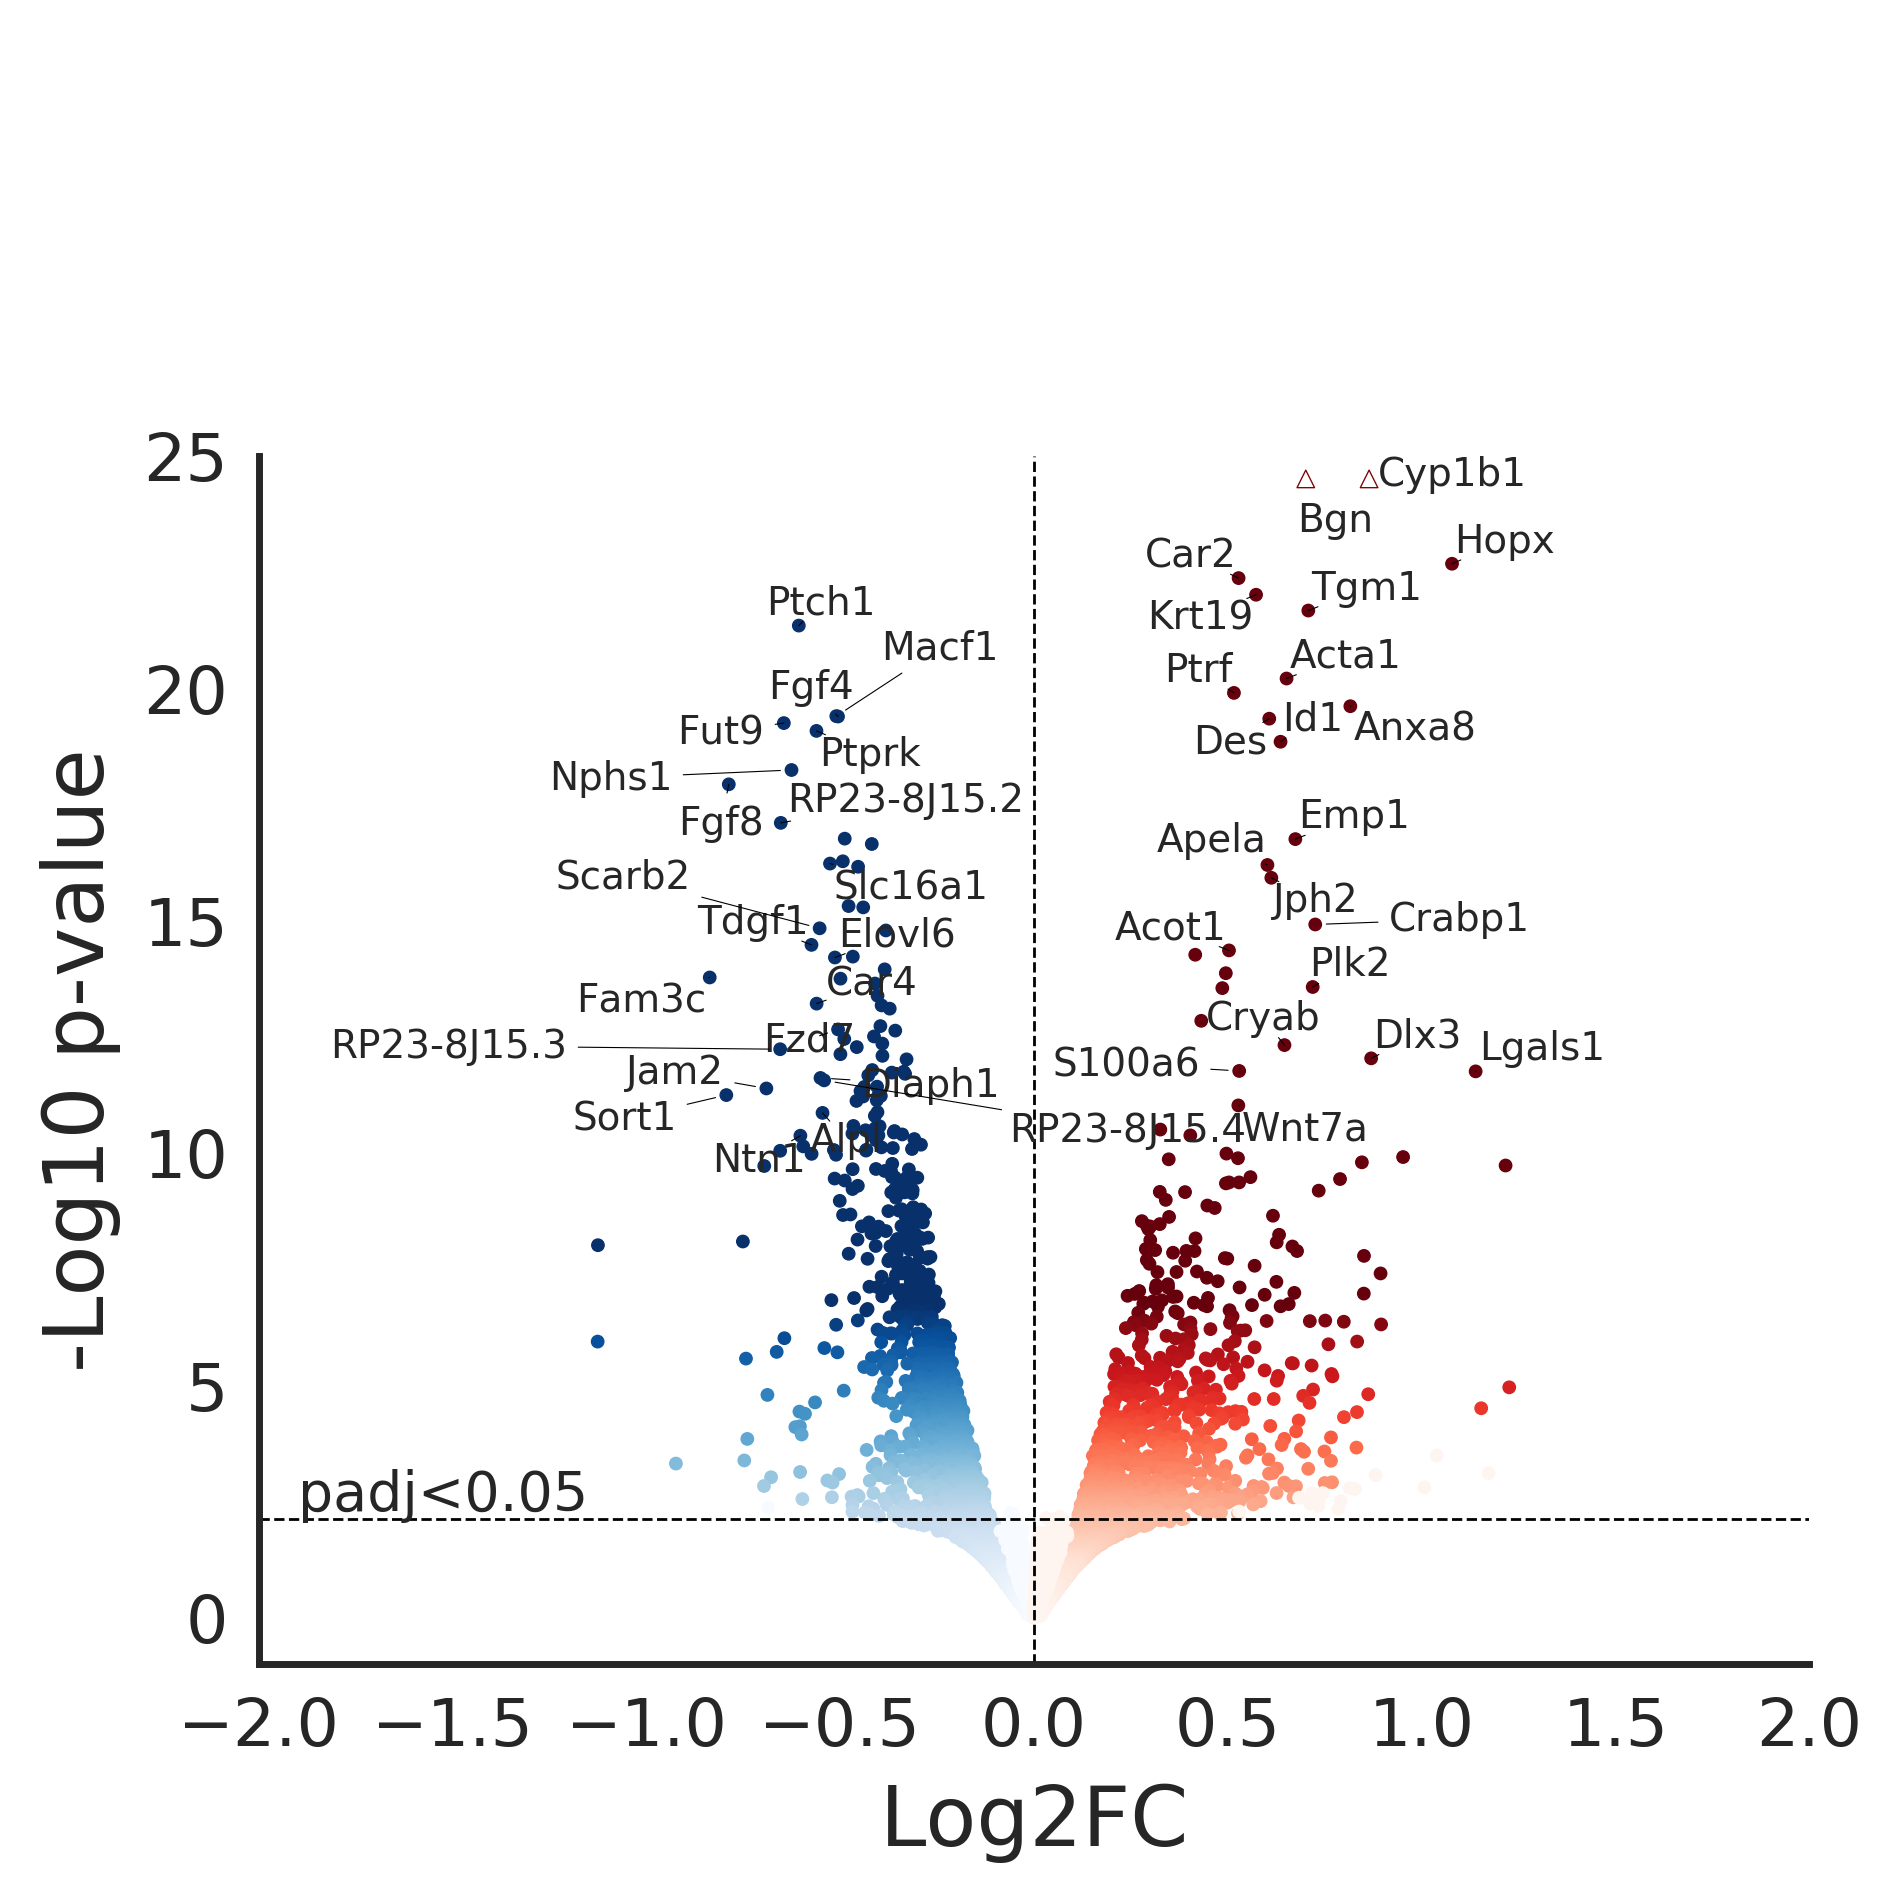

In [9]:
### VOLCANO PLOT FOR mESC ###

fig,ax=plt.subplots(dpi=400,figsize=(5,4))
esc["minLogPval"] = -np.log10(esc.pvalue)
esc["minLogPadj"] = -np.log10(esc.padj)

esc_up = esc.loc[esc.log2FoldChange>0]
esc_down = esc.loc[esc.log2FoldChange<0]

ax.set_ylim(-1,25)
ax.set_xlim(-2,2)

minima = 0
maxima = 5
norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues)
mapper.set_array(esc_down.minLogPadj)
rgba_list=[]
for v in esc_down["minLogPadj"]:
            rgba_list.append(mapper.to_rgba(v))
ax.scatter(esc_down.log2FoldChange, esc_down.minLogPval,s=5,c=rgba_list)
minima = 0
maxima = 5
norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Reds)
mapper.set_array(esc_up.minLogPadj)
rgba_list=[]
for v in esc_up["minLogPadj"]:
            rgba_list.append(mapper.to_rgba(v))

ax.scatter(esc_up.log2FoldChange, esc_up.minLogPval,s=5,c=rgba_list)
ax.axvline(0,linestyle='--',linewidth=0.5,color='k')


above = esc.loc[esc.minLogPval>25]

ax.scatter(above.log2FoldChange.values, [24.5,24.5],s=10,edgecolor=['maroon','maroon'],facecolor=["white","white"], marker="^")

padj_thr = 0.00000001

idx = esc.loc[(esc.padj<padj_thr)&(esc.log2FoldChange<-0.5)].index
idx2 = esc.loc[(esc.padj<padj_thr)&(esc.log2FoldChange>0.5)].index


texts = [plt.text(esc["log2FoldChange"].loc[idx].values[i], esc["minLogPval"].loc[idx].values[i], "{}".format(esc[["symbol"]].loc[(esc.padj<padj_thr)&(esc.log2FoldChange<0)].values[i][0]), ha='center', va='center',  fontsize=7) for i in range(len(idx))]
texts2 = [plt.text(esc["log2FoldChange"].loc[idx2].values[i], esc["minLogPval"].loc[idx2].values[i], "{}".format(esc[["symbol"]].loc[(esc.padj<padj_thr)&(esc.log2FoldChange>0)].values[i][0]), ha='center', va='center',  fontsize=7) for i in range(len(idx2))]


adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.2))
adjust_text(texts2, arrowprops=dict(arrowstyle="-", color='k', lw=0.2))

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
pthr = 0.05
pval_thr = -np.log10(esc.loc[esc.padj<pthr].tail(n=1)["pvalue"].values[0])
ax.axhline(pval_thr,linestyle='--',linewidth=0.5,color='k')
ax.annotate("padj<{}".format(pthr),[-1.9,pval_thr+0.2],size=10)
ax.set_ylabel("-Log10 p-value", fontsize=15)
ax.set_xlabel("Log2FC", fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# plt.savefig("../FIGURES/Volcano_plot_gradient_mESC.png")